In [103]:
import pandas as pd
import numpy as np
import requests
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [14]:
CLIENT_ID = 'KHPKNWLUOM2M2GOBRPPE355RX3IS2HEWCWJTP0HYY4BOYG2L'
CLIENT_SECRET = '5PJK30XKFHXCYJWVJ1ZJVQFDMWFZDKLIX5JRKUCYKLJAVAZS'
VERSION = '20200301' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: KHPKNWLUOM2M2GOBRPPE355RX3IS2HEWCWJTP0HYY4BOYG2L
CLIENT_SECRET:5PJK30XKFHXCYJWVJ1ZJVQFDMWFZDKLIX5JRKUCYKLJAVAZS


In [3]:
df = pd.read_csv('toronto_bor_neig_coord.csv')
df.head()

PostalCode           Borough                           Neighborhood  \
0        M3A        North York                             Parkwoods    
1        M4A        North York                      Victoria Village    
2        M5A  Downtown Toronto          Regent Park  ,  Harbourfront    
3        M6A        North York   Lawrence Manor  ,  Lawrence Heights    
4        M7A  Downtown Toronto                          Queen's Park    

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

In [5]:
df.shape

(103, 5)

#### Map of Toronto and its Boroughs

In [18]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto)  
    
toronto

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [15]:
df.groupby('Borough').count()

PostalCode  Neighborhood  Latitude  Longitude
Borough                                                        
Central Toronto            9             9         9          9
Downtown Toronto          19            18        19         19
East Toronto               5             4         5          5
East York                  5             5         5          5
Etobicoke                 12            12        12         12
Mississauga                1             1         1          1
North York                24            24        24         24
Scarborough               17            17        17         17
West Toronto               6             6         6          6
York                       5             5         5          5

#### Exploring Central Toronto

In [17]:
df_CT = df[df['Borough'] == 'Central Toronto']
df_CT

PostalCode          Borough  \
61        M4N  Central Toronto   
62        M5N  Central Toronto   
67        M4P  Central Toronto   
68        M5P  Central Toronto   
73        M4R  Central Toronto   
74        M5R  Central Toronto   
79        M4S  Central Toronto   
83        M4T  Central Toronto   
86        M4V  Central Toronto   

                                         Neighborhood   Latitude  Longitude  
61                                     Lawrence Park   43.728020 -79.388790  
62                                           Roselawn  43.711695 -79.416936  
67                                  Davisville  North  43.712751 -79.390197  
68                          Forest Hill  North & West  43.696948 -79.411307  
73                                North Toronto  West  43.715383 -79.405678  
74         The Annex  ,  North Midtown  ,  Yorkville   43.672710 -79.405678  
79                                        Davisville   43.704324 -79.388790  
83                    Moore Park  ,  Summerhill  East  43.689574 -79.383160  
86   Summerhill  West ,  Rathnelly  ,  South Hill ...  43.686412 -79.400049

In [23]:
central_toronto = folium.Map(location=[43.704324, -79.388790], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_CT['Latitude'], df_CT['Longitude'], df_CT['Borough'], df_CT['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(central_toronto)  
    
central_toronto

In [25]:
# explore venues in Central Torornto per neigborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
central_toronto_venues = getNearbyVenues(names=df_CT['Neighborhood'],
                                         latitudes=df_CT['Latitude'],
                                         longitudes=df_CT['Longitude']
                                         )

 Lawrence Park 
Roselawn
 Davisville  North
 Forest Hill  North & West
 North Toronto  West
 The Annex  ,  North Midtown  ,  Yorkville 
 Davisville 
 Moore Park  ,  Summerhill  East
 Summerhill  West ,  Rathnelly  ,  South Hill  ,  Forest Hill  SE ,  Deer Park 


In [33]:
central_toronto_venues.head(10)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Lawrence Park               43.728020              -79.388790   
1      Lawrence Park               43.728020              -79.388790   
2      Lawrence Park               43.728020              -79.388790   
3      Lawrence Park               43.728020              -79.388790   
4            Roselawn              43.711695              -79.416936   
5   Davisville  North              43.712751              -79.390197   
6   Davisville  North              43.712751              -79.390197   
7   Davisville  North              43.712751              -79.390197   
8   Davisville  North              43.712751              -79.390197   
9   Davisville  North              43.712751              -79.390197   

                                    Venue  Venue Latitude  Venue Longitude  \
0                    Lawrence Park Ravine       43.726963       -79.394382   
1                      Booty Camp Fitness       43.728051       -79.387853   
2                      Zodiac Swim School       43.728532       -79.382860   
3          TTC Bus #162 - Lawrence-Donway       43.728026       -79.382805   
4                 Rosalind's Garden Oasis       43.712189       -79.411978   
5                 Summerhill Market North       43.715499       -79.392881   
6                           Sherwood Park       43.716551       -79.387776   
7             Homeway Restaurant & Brunch       43.712641       -79.391557   
8                                 Winners       43.713236       -79.393873   
9  Best Western Roehampton Hotel & Suites       43.708878       -79.390880   

         Venue Category  
0                  Park  
1  Gym / Fitness Center  
2           Swim School  
3              Bus Line  
4                Garden  
5     Food & Drink Shop  
6                  Park  
7        Breakfast Spot  
8      Department Store  
9                 Hotel

In [35]:
central_toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
 Davisville                                                            35   
 Davisville  North                                                      8   
 Forest Hill  North & West                                              4   
 Lawrence Park                                                          4   
 Moore Park  ,  Summerhill  East                                        4   
 North Toronto  West                                                   18   
 Summerhill  West ,  Rathnelly  ,  South Hill  ...                     16   
 The Annex  ,  North Midtown  ,  Yorkville                             23   
Roselawn                                                                1   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
 Davisville                                                             35   
 Davisville  North                                                       8   
 Forest Hill  North & West                                               4   
 Lawrence Park                                                           4   
 Moore Park  ,  Summerhill  East                                         4   
 North Toronto  West                                                    18   
 Summerhill  West ,  Rathnelly  ,  South Hill  ...                      16   
 The Annex  ,  North Midtown  ,  Yorkville                              23   
Roselawn                                                                 1   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
 Davisville                                            35              35   
 Davisville  North                                      8               8   
 Forest Hill  North & West                              4               4   
 Lawrence Park                                          4               4   
 Moore Park  ,  Summerhill  East                        4               4   
 North Toronto  West                                   18              18   
 Summerhill  West ,  Rathnelly  ,  South Hill  ...     16              16   
 The Annex  ,  North Midtown  ,  Yorkville             23              23   
Roselawn                                                1               1   

                                                    Venue Longitude  \
Neighborhood                                                          
 Davisville                                                      35   
 Davisville  North                                                8   
 Forest Hill  North & West                                        4   
 Lawrence Park                                                    4   
 Moore Park  ,  Summerhill  East                                  4   
 North Toronto  West                                             18   
 Summerhill  West ,  Rathnelly  ,  South Hill  ...               16   
 The Annex  ,  North Midtown  ,  Yorkville                       23   
Roselawn                                                          1   

                                                    Venue Category  
Neighborhood                                                        
 Davisville                                                     35  
 Davisville  North                                               8  
 Forest Hill  North & West                                       4  
 Lawrence Park                                                   4  
 Moore Park  ,  Summerhill  East                                 4  
 North Toronto  West                                            18  
 Summerhill  West ,  Rathnelly  ,  South Hill  ...              16  
 The Annex  ,  North Midtown  ,  Yorkville                      23  
Roselawn                 

In [36]:
print('There are {} uniques categories.'.format(len(central_toronto_venues['Venue Category'].unique())))

There are 62 uniques categories.


#### Analyze Neighborhood of Central Toronto

In [37]:
# one hot encoding
central_toronto_onehot = pd.get_dummies(central_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
central_toronto_onehot['Neighborhood'] = central_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [central_toronto_onehot.columns[-1]] + list(central_toronto_onehot.columns[:-1])
central_toronto_onehot = central_toronto_onehot[fixed_columns]

central_toronto_onehot.head()

Neighborhood  American Restaurant  BBQ Joint  Bank  Breakfast Spot  \
0   Lawrence Park                     0          0     0               0   
1   Lawrence Park                     0          0     0               0   
2   Lawrence Park                     0          0     0               0   
3   Lawrence Park                     0          0     0               0   
4         Roselawn                    0          0     0               0   

   Brewery  Burger Joint  Bus Line  Café  Chinese Restaurant  ...  \
0        0             0         0     0                   0  ...   
1        0             0         0     0                   0  ...   
2        0             0         0     0                   0  ...   
3        0             0         1     0                   0  ...   
4        0             0         0     0                   0  ...   

   Supermarket  Sushi Restaurant  Swim School  Tennis Court  Thai Restaurant  \
0            0                 0            0             0                0   
1            0                 0            0             0                0   
2            0                 0            1             0                0   
3            0                 0            0             0                0   
4            0                 0            0             0                0   

   Toy / Game Store  Trail  Vegetarian / Vegan Restaurant  \
0                 0      0                              0   
1                 0      0                              0   
2                 0      0                              0   
3                 0      0                              0   
4                 0      0                              0   

   Vietnamese Restaurant  Yoga Studio  
0                      0            0  
1                      0            0  
2                      0            0  
3                      0            0  
4                      0            0  

[5 rows x 63 columns]

In [38]:
CT_grouped = central_toronto_onehot.groupby('Neighborhood').mean().reset_index()
CT_grouped

Neighborhood  American Restaurant  \
0                                        Davisville              0.000000   
1                                  Davisville  North             0.000000   
2                          Forest Hill  North & West             0.000000   
3                                     Lawrence Park              0.000000   
4                    Moore Park  ,  Summerhill  East             0.000000   
5                                North Toronto  West             0.000000   
6   Summerhill  West ,  Rathnelly  ,  South Hill ...             0.062500   
7         The Annex  ,  North Midtown  ,  Yorkville              0.043478   
8                                           Roselawn             0.000000   

   BBQ Joint    Bank  Breakfast Spot   Brewery  Burger Joint  Bus Line  \
0   0.000000  0.0000           0.000  0.028571      0.000000      0.00   
1   0.000000  0.0000           0.125  0.000000      0.000000      0.00   
2   0.000000  0.0000           0.000  0.000000      0.000000      0.00   
3   0.000000  0.0000           0.000  0.000000      0.000000      0.25   
4   0.000000  0.0000           0.000  0.000000      0.000000      0.00   
5   0.000000  0.0000           0.000  0.000000      0.000000      0.00   
6   0.000000  0.0625           0.000  0.000000      0.062500      0.00   
7   0.043478  0.0000           0.000  0.000000      0.043478      0.00   
8   0.000000  0.0000           0.000  0.000000      0.000000      0.00   

       Café  Chinese Restaurant  ...  Supermarket  Sushi Restaurant  \
0  0.057143            0.000000  ...       0.0000          0.057143   
1  0.000000            0.000000  ...       0.0000          0.000000   
2  0.000000            0.000000  ...       0.0000          0.250000   
3  0.000000            0.000000  ...       0.0000          0.000000   
4  0.000000            0.000000  ...       0.0000          0.000000   
5  0.055556            0.055556  ...       0.0000          0.000000   
6  0.000000            0.000000  ...       0.0625          0.062500   
7  0.130435            0.000000  ...       0.0000          0.000000   
8  0.000000            0.000000  ...       0.0000          0.000000   

   Swim School  Tennis Court  Thai Restaurant  Toy / Game Store  Trail  \
0         0.00          0.00         0.028571          0.028571   0.00   
1         0.00          0.00         0.000000          0.000000   0.00   
2         0.00          0.00         0.000000          0.000000   0.25   
3         0.25          0.00         0.000000          0.000000   0.00   
4         0.00          0.25         0.000000          0.000000   0.00   
5         0.00          0.00         0.000000          0.000000   0.00   
6         0.00          0.00         0.000000          0.000000   0.00   
7         0.00          0.00         0.000000          0.000000   0.00   
8         0.00          0.00         0.000000          0.000000   0.00   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Yoga Studio  
0                       0.000000                 0.0000     0.000000  
1                       0.000000                 0.0000     0.000000  
2                       0.000000                 0.0000     0.000000  
3                       0.000000                 0.0000     0.000000  
4                       0.000000                 0.0000     0.000000  
5                       0.000000                 0.0000     0.055556  
6                       0.000000                 0.0625     0.000000  
7                       0.043478                 0.0000     0.000000  
8                       0.000000                 0.0000     0.000000  

[9 rows x 63 columns]

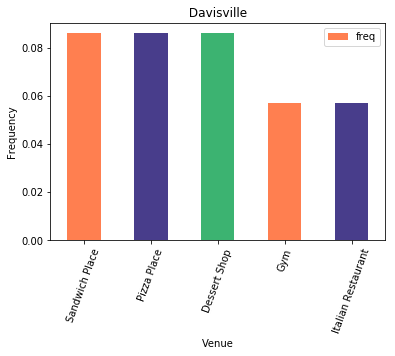

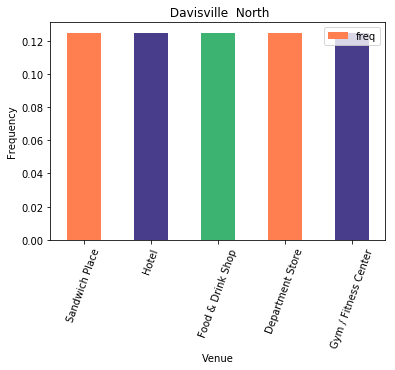

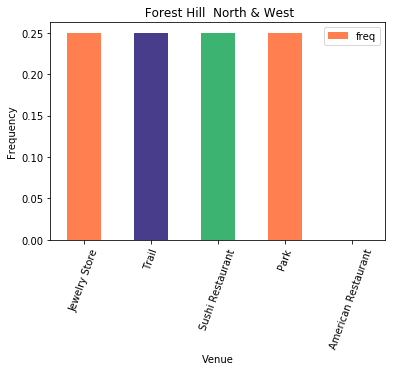

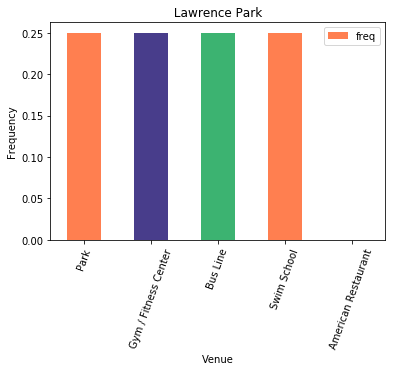

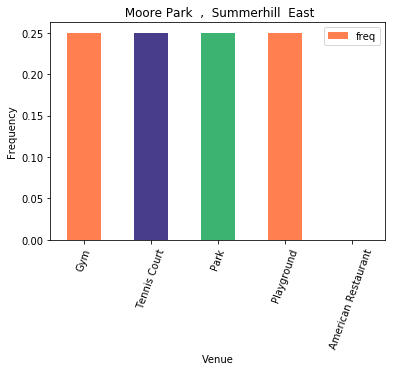

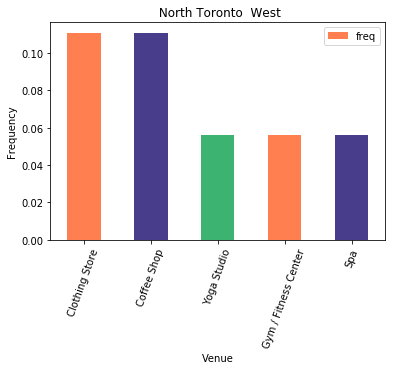

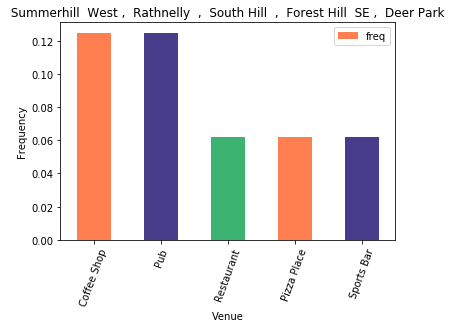

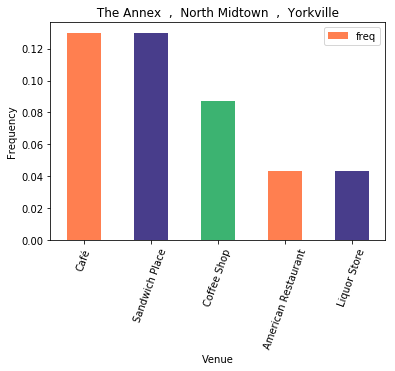

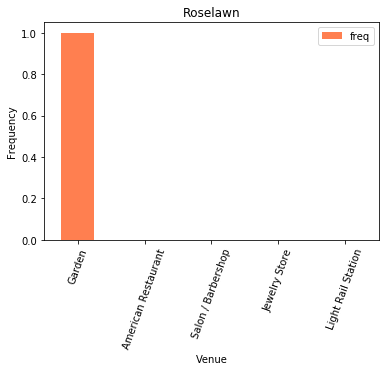

In [70]:
num_top_venues = 5

for neig in CT_grouped['Neighborhood']:
    temp = CT_grouped[CT_grouped['Neighborhood'] == neig].T.reset_index() # transpose
    temp.columns = ['venue','freq'] # set new column name
    temp = temp.iloc[1:] # strip first line
    temp['freq'] = temp['freq'].astype(float) # set type float
    temp = temp.round({'freq': 3}) # round float to 3 decimal digit
    top = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues) # get TOP
    # PLOTTING
    top.plot(kind='bar' , x='venue', y='freq', color=['coral', 'darkslateblue', 'mediumseagreen'])
    plt.title(neig)
    plt.xlabel('Venue')
    plt.xticks(rotation=70)
    plt.ylabel('Frequency')
    plt.show()

In [96]:
def return_most_common_venues(row, num_top_venues):
    idx = 0
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    indexes = row_categories_sorted.index.values[0:num_top_venues]
    values = row_categories_sorted.iloc[:num_top_venues]
    for idx, val in enumerate(values):
        if val == 0:
            indexes[idx] = 'N/A'
    
    return indexes

In [97]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CT_grouped['Neighborhood']

for ind in np.arange(CT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

Neighborhood 1st Most Common Venue  \
0                                        Davisville         Sandwich Place   
1                                  Davisville  North      Department Store   
2                          Forest Hill  North & West      Sushi Restaurant   
3                                     Lawrence Park               Bus Line   
4                    Moore Park  ,  Summerhill  East                   Gym   
5                                North Toronto  West           Coffee Shop   
6   Summerhill  West ,  Rathnelly  ,  South Hill ...                   Pub   
7         The Annex  ,  North Midtown  ,  Yorkville                   Café   
8                                           Roselawn                Garden   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Pizza Place          Dessert Shop           Coffee Shop   
1     Food & Drink Shop        Sandwich Place                  Park   
2                 Trail                  Park         Jewelry Store   
3  Gym / Fitness Center                  Park           Swim School   
4          Tennis Court                  Park            Playground   
5        Clothing Store           Yoga Studio                   Spa   
6           Coffee Shop   American Restaurant    Light Rail Station   
7        Sandwich Place           Coffee Shop     Indian Restaurant   
8                   N/A                   N/A                   N/A   

  5th Most Common Venue  
0                  Café  
1                 Hotel  
2                   N/A  
3                   N/A  
4                   N/A  
5  Fast Food Restaurant  
6           Pizza Place  
7                   Pub  
8                   N/A

#### Clustering Neighborhoods

In [99]:
# set number of clusters
kclusters = 5

CT_clustering = CT_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CT_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 3, 4, 2, 0, 0, 0, 1], dtype=int32)

In [100]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

CT_merged = df_CT

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
CT_merged = CT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

CT_merged.head() # check the last columns!

PostalCode          Borough                Neighborhood   Latitude  \
61        M4N  Central Toronto              Lawrence Park   43.728020   
62        M5N  Central Toronto                    Roselawn  43.711695   
67        M4P  Central Toronto           Davisville  North  43.712751   
68        M5P  Central Toronto   Forest Hill  North & West  43.696948   
73        M4R  Central Toronto         North Toronto  West  43.715383   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
61 -79.388790               4              Bus Line  Gym / Fitness Center   
62 -79.416936               1                Garden                   N/A   
67 -79.390197               0      Department Store     Food & Drink Shop   
68 -79.411307               3      Sushi Restaurant                 Trail   
73 -79.405678               0           Coffee Shop        Clothing Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
61                  Park           Swim School                   N/A  
62                   N/A                   N/A                   N/A  
67        Sandwich Place                  Park                 Hotel  
68                  Park         Jewelry Store                   N/A  
73           Yoga Studio                   Spa  Fast Food Restaurant

In [104]:
clustered = folium.Map(location=[43.704324, -79.388790], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CT_merged['Latitude'], CT_merged['Longitude'], CT_merged['Neighborhood'], CT_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clustered)
       
clustered